# Introduction

This notebook is part of the bachelor's thesis *Solving the 3-SAT problem using quantum algorithms* done by *Arnau Casau* at *FIB - UPC Universitat Politècnica de Catalunya*.

In this notebook, we will see an implementation of Grover's algorithm to solve the 3-SAT problem using Quiskit. We can find some explanation of the code in order to better understand the results, and for further details, I encourage the reader to go to the actual thesis document.

# Grover's algorithm to solve 3-SAT

We can break up Grover's algorithm into the following five steps:

* 1) Create an equal superposition of all qubits.
* 2) Apply the oracle O
* 3) Apply the Hadamard transform $H^{⊗n}$
* 4) Perform a conditional phase shift $D_4$ of -1 to all the states but the state $|0⟩^{⊗n}$ (Diffuser)
* 5) Apply the Hadamard transform $H^{⊗n}$

Steps 2, 3, 4, and 5 are repeated R times to increment the probability of obtaining a solution state at maximum. To determine R, we need to know beforehand the number of solutions that our formula has, but this is a problem because, at this point, we don't know if the problem has a solution, let alone how many there are. To solve this problem, we will use the Quantum counting algorithm later.

**1) Create an equal superposition of all qubits**

In this first step to create an equal superposition state, we apply the Hadamard transformation to all qubits. Our system is, initially, in the pure state $|0⟩^{⊗n}$. Assuming $N = 2^n$:

$|\phi⟩$ = $H^{⊗n}$ $|0⟩^{⊗n}$ = $1\over{\sqrt{N}}$ $\sum_{x=0}^{N-1} |x⟩$

Our goal with this algorithm is to find one state that satisfies the given formula. Each quantum state represents a possible assignment of the literals. In the previous state, we have a superposition of all possible assignments, but we can represent the same by splitting out the no solution states, which we will call $|\alpha⟩$, and the solutions states, which we will call $|\beta⟩$.

$|\alpha⟩$ = $1\over{\sqrt{N-M}}$ $\sum_{x \in No Sol}^{} |x⟩$

$|\beta⟩$ = $1\over{\sqrt{M}}$ $\sum_{x \in Sol}^{} |x⟩$

Therefore, we can express $|\phi⟩$ as:

$|\phi⟩$ = $\sqrt{{N-M}\over{N}}$ $|\alpha⟩$ + $\sqrt{{M}\over{N}}$ $|\beta⟩$

**2) Apply the oracle O**

In this step, the oracle will mark the solution states of the 3-SAT formula we are trying to solve. To do so, the oracle will perform a conditional phase shift of -1 to all solution states. We can see the oracle as the following formula:

O : $|\beta⟩$ = -$|\beta⟩$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $|x⟩$ = $|x⟩$ $\forall x \notin Sol$

Analogically, we can see the same formula but using Dirac notation. The expression *I* stands for the identity matrix:

O = $I -2|\beta⟩⟨\beta|$

**3), 4), 5) Inversion about the mean**

We can represent steps 3, 4, and 5 together as one transformation. Before doing that, we can represent step 4 with Dirac notation as follows:

$D_4$ = $2|0⟩⟨0|^{⊗n} - I$

Steps 3 and 5 are the same, so if we apply the Hadamard transformations front and back to the expression from step 4 above, we end up with the following:

$D = H^{⊗n} D_4 H^{⊗n}= H^{⊗n}$ ($2|0⟩⟨0|^{⊗n} - I$) $H^{⊗n}$ = $2|\phi⟩⟨\phi|^{⊗n} - I$

The last equality is because, as we have seen in step 1, $H^{⊗n}$$|0⟩$ = $|\phi⟩$

To summarize, we need to apply the following transformations to the state in the first step, in that specific order, to apply steps 3, 4, and 5.

* O = $I -2|\beta⟩⟨\beta|$
* D = $2|\phi⟩⟨\phi|^{⊗n} - I$

We will call the application of those transformations $G = D O$

We can see these two transformations, geometrically, as two reflections. The first one is over the state $|\beta⟩$, and the second is over the state $|\phi⟩$. As we know, two reflections are equivalent to one rotation, so we can conclude that we are rotating our state by a certain angle $\theta$ every time we apply steps 2, 3, 4, and 5. This angle gives us information about the number of solutions we have in our problem, and we will take advantage of that when we look for it in the quantum counting algorithm.

**Geometrically**

In the following image, we can see a geometrical interpretation of the rotation in Grover's algorithm. We can also represent our quantum state $|\phi⟩$ as follows:

$|\phi⟩$ = cos($\theta \over{2}$) $|\alpha⟩$ + sin($\theta \over{2}$) $|\beta⟩$

In this image, we see the application of the two reflections as one rotation of our state:


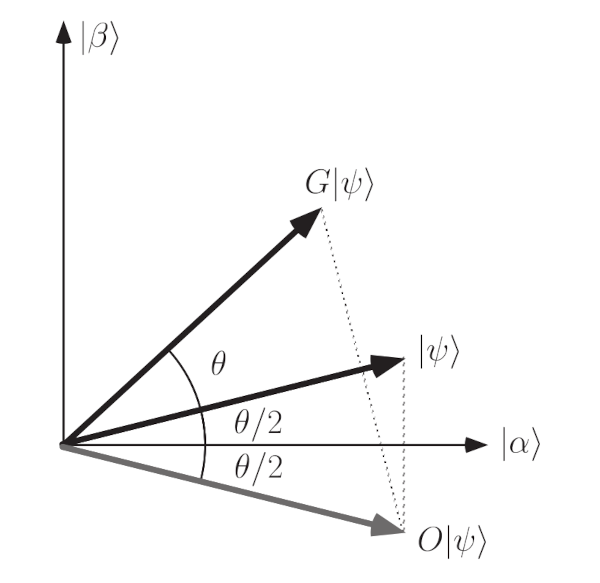

*The action of a single Grover iteration. Quantum Computation and Quantum Information by Michael A. Nielsen & Isaac L. Chuang, page 253.*

In [1]:
# imports
import math

# importing Qiskit
from qiskit import QuantumCircuit, Aer, assemble, transpile
from qiskit.visualization import plot_histogram

In order to try different formulas, we can use a text file. This text file has to contain a first line specifying the number of literals and clauses that we will use and next, all the clauses separated by an end line. The notebook reads files in DIMACS format, and additionally, we don't need a 0 at the end of each clause, but it could appear.

In [2]:
f = open("cnf_test1.txt")
info = f.readline().split(' ')
literals = int(info[0])
clausulas = int(info[1])

lines = [line.rstrip('\n') for line in f]

formula = []
for i in lines:
    l = i.split(' ')
    formula.append([int(l[0]),int(l[1]),int(l[2])])

In the next cell, we can see the number of qubits we will use in our circuit. We will use one qubit for each literal, one qubit for each clause, and another qubit that represents the state |-⟩ used to perform the phase shift of -1 if the assignment satisfies our formula. The last extra qubit represents a *hidden* literal used to double the state space, which I will force to be 0 in the final assignment. That has to be done to avoid the problem that the algorithm gives us no solutions states instead of solutions states if our formula has more than half of the possible assignments that satisfy it.

In [3]:
n = literals + 1 + clausulas + 1 # Number of qubits in the circuit

Step 1 function of Grover's algorithm:

In [4]:
def initialize_grover(qc, qubits):
    # Superposition
    for i in range(literals+1):
        qc.h(qubits[i])
        
    # State |-⟩
    qc.x(n-1)
    qc.h(n-1)
    
    return qc

Now, we are going to create a quantum gate that will represent the oracle in step 2.

The SAT formulas that we use are in conjunctive normal form (CNF). This is an example of a formula where {x1,x2,x3} are the literals and {-x1,-x2,-x3} are their negations:

(-x1 v -x2 v -x3) ∧ (x1 v x2 v x3) ∧ (x1 v -x2 v x3)

To discover if a clause is evaluated as True, we can check if its negated version is Flase. If we do so, we will have clauses in a literal's conjunction as a result. The first clause of the previous formula will be:

(-x1 v -x2 v -x3) --> (x1 ∧ x2 ∧ x3)

We will negate the clauses because it is easier to implement a circuit with an and gates than one with an or gates. For its implementation, we will use a controlled Toffoli gate. In case all of the negated clauses of an assignment are evaluated as False, we will know that the same formula in CNF with that assignment is evaluated as True, and thus it's a solution. For that reason, when we will perform the phase shift of -1, we will negate all the clause's qubits to determine whether it's a solution or not using the Toffoli gate, as we can see in the following code cell:

In [5]:
qc = QuantumCircuit(n)

# Creation of each clause.
contador = 0
for c in formula:
    for i in range(3):
        if c[i] > 0:
            qc.x(abs(c[i])-1)
            
    qc.mct(list([abs(c[0])-1,abs(c[1])-1,abs(c[2])-1]), literals+1+contador)  # multi-controlled-toffoli
    
    for i in range(3):
        if c[2-i] > 0:
            qc.x(abs(c[2-i])-1)
    
    contador+=1


# Checking of each clause
qc.x(literals) # Augmented space
for q in range(literals+1,n-1):
    qc.x(q)
    
qc.mct(list(list([literals, *range(literals+1,n-1)])), n-1)

for q in range(literals+1,n-1):
    qc.x(q)
qc.x(literals) # Augmented space


# Creation of each clause (symmetry).    
contador -= 1
for c in reversed(formula):
    for i in range(3):
        if c[i] > 0:
            qc.x(abs(c[i])-1)
            
    qc.mct(list([abs(c[0])-1,abs(c[1])-1,abs(c[2])-1]), literals+1+contador)
    
    for i in range(3):
        if c[2-i] > 0:
            qc.x(abs(c[2-i])-1)
    
    contador-=1

oracle = qc.to_gate()
oracle.name = "Oracle"
qc.draw()

┌───┐     ┌───┐┌───┐     ┌───┐┌───┐          ┌───┐┌───┐     ┌───┐»
q_0: ──■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├───────■──┤ X ├┤ X ├──■──┤ X ├»
       │  ├───┤  │  ├───┤└───┘  │  └───┘└───┘       │  ├───┤└───┘  │  ├───┤»
q_1: ──■──┤ X ├──■──┤ X ├───────■───────────────────■──┤ X ├───────■──┤ X ├»
       │  ├───┤  │  ├───┤┌───┐  │  ┌───┐┌───┐       │  ├───┤┌───┐  │  ├───┤»
q_2: ──■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├───────■──┤ X ├┤ X ├──■──┤ X ├»
       │  └───┘  │  └───┘└───┘  │  └───┘└───┘       │  └───┘└───┘  │  └───┘»
q_3: ──┼─────────┼──────────────┼───────────────────┼──────────────┼───────»
       │         │              │                   │              │       »
q_4: ──┼─────────┼──────────────┼───────────────────┼──────────────┼───────»
       │  ┌───┐  │              │            ┌───┐  │              │       »
q_5: ──┼──┤ X ├──┼──────────────┼─────────■──┤ X ├──┼──────────────┼───────»
     ┌─┴─┐├───┤  │              │         │  ├───┤  │              │       »
q_6: ┤ X ├┤ X ├──┼──────────────┼─────────■──┤ X ├──┼──────────────┼───────»
     └───┘└───┘┌─┴─┐┌───┐       │         │  ├───┤  │            ┌─┴─┐     »
q_7: ──────────┤ X ├┤ X ├───────┼─────────■──┤ X ├──┼────────────┤ X ├─────»
               └───┘└───┘     ┌─┴─┐┌───┐  │  ├───┤┌─┴─┐          └───┘     »
q_8: ─────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├────────────────────»
                              └───┘└───┘┌─┴─┐└───┘└───┘                    »
q_9: ───────────────────────────────────┤ X ├──────────────────────────────»
                                        └───┘                              »
«          
«q_0: ──■──
«       │  
«q_1: ──■──
«       │  
«q_2: ──■──
«       │  
«q_3: ──┼──
«       │  
«q_4: ──┼──
«       │  
«q_5: ──┼──
«     ┌─┴─┐
«q_6: ┤ X ├
«     └───┘
«q_7: ─────
«          
«q_8: ─────
«          
«q_9: ─────
«

Once we have created the oracle gate, we can create another gate representing steps 3, 4, and 5 of Grover's algorithm. These steps, together, are also called inversion about the mean.

In [6]:
qc = QuantumCircuit(n)

for qubit in range(literals+1):
        qc.h(qubit)
        
for qubit in range(literals+1):
        qc.x(qubit)
        
# Equivalent Diffuser. It gives us the opposite result, therefore M will be the number of no solutions at the end.
qc.mct(list([i for i in range(literals+1)]), n-1)

########## Original Diffuser ##############################################################
#qc.mct(list([i for i in range(literals+1)]), literals+1)
#qc.x(literals+1)
#qc.cx(literals+1,n-1)
#qc.x(literals+1)
#qc.mct(list([i for i in range(literals+1)]), literals+1)
###########################################################################################

for qubit in range(literals+1):
        qc.x(qubit)
        
for qubit in range(literals+1):
        qc.h(qubit)

inversionMean = qc.to_gate()
inversionMean.name = "inversionMean"
qc.draw()

┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_2: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_3: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_4: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_5: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     └───┘└───┘  │  └───┘└───┘
q_6: ────────────┼────────────
                 │            
q_7: ────────────┼────────────
                 │            
q_8: ────────────┼────────────
               ┌─┴─┐          
q_9: ──────────┤ X ├──────────
               └───┘

At this stage, we have created all the gates to run Grover's algorithm, but we still don't know how many solutions we have. Without that information, we don't know the number of iterations, R, that we have to do either. To discover it, we will use the Quantum counting algorithm that uses the Quantum phase estimation algorithm and steps 2, 3, 4, and 5 of our search algorithm to find the angle $\theta$ that we have seen at the beginning of this notebook.

Next, we will create another gate corresponding to one iteration of Grover's (steps 2, 3, 4, and 5). As we can see down below, we are using the gates created previously.

In [7]:
grover_iteration = QuantumCircuit(n)

grover_iteration.append(oracle, list(range(n)))
grover_iteration.append(inversionMean, list(range(n)))

gi = grover_iteration.to_gate()
gi.label = "GroverI"
cgi = gi.control()

## Quantum phase estimation

Before using the Quantum phase estimation (QPE), we need to define the Quantum Fourier transform (QFT). This transformation is analogous to its classical discrete version. We can represent it as follows:

$|\hat{x}⟩$ = $1\over{\sqrt{N}}$ $\sum_{y = 0}^{N-1} e^{{2 \pi i x y}\over{N}} |y⟩$ = 

$|\hat{x}⟩$ = $1\over{\sqrt{N}}$ $\sum_{y_1 = 0}^{1} \sum_{y_2 = 0}^{1} ... \sum_{y_n = 0}^{1} e^{2 \pi i x (\sum_{l = 1}^{n} y_l \cdot 2^{-l})} |y_1y_2...y_n⟩$ =

$|\hat{x}⟩$ = $1\over{\sqrt{N}}$ $\sum_{y_1 = 0}^{1} \sum_{y_2 = 0}^{1} ... \sum_{y_n = 0}^{1} ⊗_{l=1}^{n} e^{2 \pi i x y_l \cdot 2^{-l}} |y_1y_2...y_n⟩$ =

$|\hat{x}⟩$ = $1\over{\sqrt{N}}$ $⊗_{l=1}^{n}$ $[\sum_{y = 0}^{1} e^{{2 \pi i x y}\over{N}} |y⟩]$ =

$|\hat{x}⟩$ = ${1}\over{\sqrt{N}}$ $\cdot (|0⟩+e^{{2\pi i x}\over{2^1}} |1⟩)$ $\cdot (|0⟩+e^{{2\pi i x}\over{2^2}} |1⟩) \cdot$ ... $\cdot (|0⟩+e^{{2\pi i x}\over{2^n}} |1⟩)$

As we can see, to reach the result, we have been changing the notation of our qubit between its decimal form |y⟩ and its binary form  $|y_1y_2...y_n⟩$.

In the following code cell, we have a function that creates the circuit of QFT:

In [8]:
def qft(n):
    circuit = QuantumCircuit(n)
    
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    
    def qft_rotations(circuit, n):
        #Performs qft on the first n qubits in circuit (without swaps)
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(math.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)  # Comment this line if we use the 2 possible order of the QPE registers
    return circuit

In the previous cell, we created the QFT, but to run the QPE, we will need the inverse of that circuit. To get the inverse of the QFT, we can convert our function into a gate and use the *inverse* function as follows:

In [9]:
t = literals+1  # Number of counting qubits.
qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"

In the next cell, we can see the Quantum phase estimation algorithm we will use to obtain the angle $\theta$. In this algorithm, we use t qubits to predict the angle. The more qubits we use, the lower the precision error in $\theta$.

As we can see, in this algorithm, we apply the gate *GroverI* created before raised successively to the powers of 2, using this gate with his controlled version. By doing that, we get the following expression:

$|\hat{x}⟩$ = ${1}\over{\sqrt{2^t}}$ $\cdot (|0⟩+e^{{i \cdot \theta \cdot 2^{t-1}}} |1⟩)$ $\cdot (|0⟩+e^{{i \cdot \theta \cdot 2^{t-2}}} |1⟩) \cdot$ ... $\cdot (|0⟩+e^{{i \cdot \theta \cdot 2^{0}}} |1⟩)$

This expression is similar to the one obtained in the quantum Fourier transform, and therefore, applying the inverse of QFT, we can get the angle $\theta$ that we want. If we compare the first terms of each expression, we can see that they are only different in one exponent.

QFT: $(|0⟩+e^{{2\pi i x}\over{2^1}} |1⟩)$

QPE: $(|0⟩+e^{{i \cdot \theta \cdot 2^{t-1}}} |1⟩)$

If we apply the inverse of the QFT, we will obtain the *x* in the exponent because it was the input in that function. Comparing the two exponents, we can see what value will take *x* after applying the Quantum phase estimation.

$e^{{2\pi i x}\over{2^1}}$ = $e^{{i \cdot \theta \cdot 2^{t-1}}}$

${2\pi i x}\over{2^1}$ = ${i \cdot \theta \cdot 2^{t-1}}$

$x$ = ${\theta \cdot 2^{t}}\over{2\pi}$

With that in mind, we can extract the angle needed to determine the number of solutions later. Down below, we can see the complete circuit of the quantum counting algorithm:

In [10]:
qpe = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Superposició
for qubit in range(t+literals+1):
    qpe.h(qubit)

# Estat |-⟩
qpe.x(n+t-1)
qpe.h(n+t-1)
    
# Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qpe.append(cgi, [qubit] + [*range(t, n+t)])   # Using this line, uncomment the QFT swap.
        #qpe.append(cgrit, [(t-1)-qubit] + [*range(t, n+t)]) # Using this line, comment the QFT swap.

    iterations *= 2
    
# Aplicar la QFT inversa als counting qubits
qpe.append(qft_dagger, range(t))

# Mesurar els counting qubits
qpe.measure(range(t), range(t))

qpe.draw()

┌───┐                                                                 »
 q_0: ┤ H ├──────────■──────────────────────────────────────────────────────»
      ├───┤          │                                                      »
 q_1: ┤ H ├──────────┼───────────■───────────■──────────────────────────────»
      ├───┤          │           │           │                              »
 q_2: ┤ H ├──────────┼───────────┼───────────┼───────────■───────────■──────»
      ├───┤          │           │           │           │           │      »
 q_3: ┤ H ├──────────┼───────────┼───────────┼───────────┼───────────┼──────»
      ├───┤          │           │           │           │           │      »
 q_4: ┤ H ├──────────┼───────────┼───────────┼───────────┼───────────┼──────»
      ├───┤          │           │           │           │           │      »
 q_5: ┤ H ├──────────┼───────────┼───────────┼───────────┼───────────┼──────»
      ├───┤     ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
 q_6: ┤ H ├─────┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
      ├───┤     │          ││          ││          ││          ││          │»
 q_7: ┤ H ├─────┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
      ├───┤     │          ││          ││          ││          ││          │»
 q_8: ┤ H ├─────┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
      ├───┤     │          ││          ││          ││          ││          │»
 q_9: ┤ H ├─────┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
      ├───┤     │          ││          ││          ││          ││          │»
q_10: ┤ H ├─────┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
      ├───┤     │  GroverI ││  GroverI ││  GroverI ││  GroverI ││  GroverI │»
q_11: ┤ H ├─────┤5         ├┤5         ├┤5         ├┤5         ├┤5         ├»
      └───┘     │          ││          ││          ││          ││          │»
q_12: ──────────┤6         ├┤6         ├┤6         ├┤6         ├┤6         ├»
                │          ││          ││          ││          ││          │»
q_13: ──────────┤7         ├┤7         ├┤7         ├┤7         ├┤7         ├»
                │          ││          ││          ││          ││          │»
q_14: ──────────┤8         ├┤8         ├┤8         ├┤8         ├┤8         ├»
      ┌───┐┌───┐│          ││          ││          ││          ││          │»
q_15: ┤ X ├┤ H ├┤9         ├┤9         ├┤9         ├┤9         ├┤9         ├»
      └───┘└───┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
 c_0: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_1: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_2: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_3: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_4: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_5: ══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
« q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                              »
« q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                              »
« q_2: ─────■───────────■──────────────────────────────────────────────────────»
«         

In the graphic below, we can see the results obtained after running the quantum counting circuit depicted above.

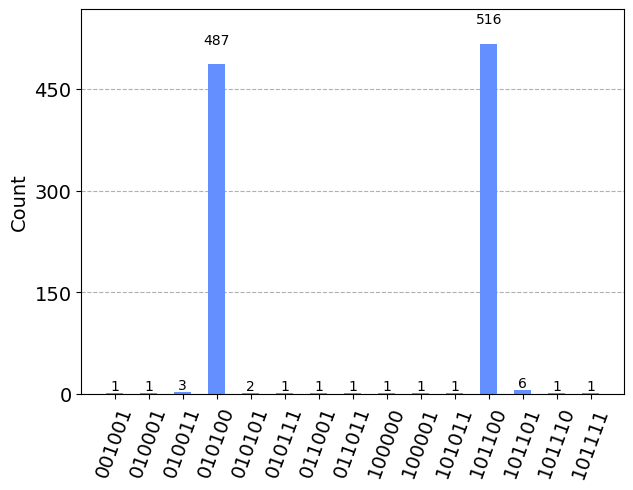

In [11]:
# Quantum counting sinulation
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qpe = transpile(qpe, aer_sim)
qobj = assemble(transpiled_qpe)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

After obtaining the *x* in the QFT, we can extract the angle of one Grover's iteration like this:

$\theta$ = ${2\pi x}\over{2^t}$

In [12]:
measured_str = max(hist, key=hist.get)

In [13]:
measured_int = int(measured_str,2)
print(measured_str)
print("Register Output = %i" % measured_int)

101100
Register Output = 44


In [14]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 4.31969


Now, we can calculate the number of assignments that satisfy our formula with the angle $\theta$. At the beginning of this notebook, we have defined our state as follows:

$|\phi⟩$ = $\sqrt{N-M\over{N}}$ $|\alpha⟩$ + $\sqrt{M\over{N}}$ $|\beta⟩$

We know that the phases squared have to sum 1, so we can represent the state as follows:

$|\phi⟩$ = cos($\theta \over{2}$) $|\alpha⟩$ + sin($\theta \over{2}$) $|\beta⟩$

Therefore, we can conclude:

$\sqrt{M\over{N}}$ = sin($\theta \over{2}$)

$M$ = ${sin}^{2}({{\theta}\over{2}}) \cdot N$

In [15]:
N = 2**(literals+1)
M = N * (math.sin(theta/2)**2)
print(N,M)
print("No. of Solutions = %.1f" % (N-M)) # Diffuser upside down (faster)
#print("No. of Solutions = %.1f" % M) # Diffuser original (slower)

64 44.24586983568288
No. of Solutions = 19.8


In [16]:
# Upper bound error for the number of solutions
m = t - 1
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.38


## Grover's algorithm

Now, we have all the ingredients to execute Grover's algorithm. To calculate the number of iterations R in order to maximize the probability of obtaining a solution state, we can use the following upper bound:

$R \le \lceil {{\pi}\over{4}} \cdot \sqrt{{N}\over{M}}  \rceil$

In the worst-case scenario, our formula has only one solution and therefore leads us to a time complexity of $O(\sqrt{N})$ for Grover's algorithm.

In [17]:
rounds = math.pi/4.0*math.sqrt(N/M)
print("Result:",rounds)
print("Iterations R ≤",math.ceil(rounds))

if math.floor(rounds) == 0:
    rounds = round(rounds)
else:
    rounds = math.floor(rounds)

print("Iterations chosen:", rounds)

Result: 0.9445903395344614
Iterations R ≤ 1
Iterations chosen: 1


In the next cell, we can see Grover's algorithm and its circuit depicted:

In [18]:
grover_circuit = QuantumCircuit(n,literals)

grover_circuit = initialize_grover(grover_circuit, list(range(n)))
for i in range(rounds):
    grover_circuit.append(oracle, list(range(n)))
    grover_circuit.append(inversionMean, list(range(n)))

for i in range(literals):
    grover_circuit.measure([i],[i])

grover_circuit.draw()

┌───┐     ┌─────────┐┌────────────────┐┌─┐            
q_0: ┤ H ├─────┤0        ├┤0               ├┤M├────────────
     ├───┤     │         ││                │└╥┘┌─┐         
q_1: ┤ H ├─────┤1        ├┤1               ├─╫─┤M├─────────
     ├───┤     │         ││                │ ║ └╥┘┌─┐      
q_2: ┤ H ├─────┤2        ├┤2               ├─╫──╫─┤M├──────
     ├───┤     │         ││                │ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├─────┤3        ├┤3               ├─╫──╫──╫─┤M├───
     ├───┤     │         ││                │ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├─────┤4        ├┤4               ├─╫──╫──╫──╫─┤M├
     ├───┤     │  Oracle ││  inversionMean │ ║  ║  ║  ║ └╥┘
q_5: ┤ H ├─────┤5        ├┤5               ├─╫──╫──╫──╫──╫─
     └───┘     │         ││                │ ║  ║  ║  ║  ║ 
q_6: ──────────┤6        ├┤6               ├─╫──╫──╫──╫──╫─
               │         ││                │ ║  ║  ║  ║  ║ 
q_7: ──────────┤7        ├┤7               ├─╫──╫──╫──╫──╫─
               │         ││                │ ║  ║  ║  ║  ║ 
q_8: ──────────┤8        ├┤8               ├─╫──╫──╫──╫──╫─
     ┌───┐┌───┐│         ││                │ ║  ║  ║  ║  ║ 
q_9: ┤ X ├┤ H ├┤9        ├┤9               ├─╫──╫──╫──╫──╫─
     └───┘└───┘└─────────┘└────────────────┘ ║  ║  ║  ║  ║ 
c_0: ════════════════════════════════════════╩══╬══╬══╬══╬═
                                                ║  ║  ║  ║ 
c_1: ═══════════════════════════════════════════╩══╬══╬══╬═
                                                   ║  ║  ║ 
c_2: ══════════════════════════════════════════════╩══╬══╬═
                                                      ║  ║ 
c_3: ═════════════════════════════════════════════════╩══╬═
                                                         ║ 
c_4: ════════════════════════════════════════════════════╩═

Finally, we can see the results obtained after running the principal circuit. The results represent all the assignments written as binary strings that satisfy our formula.


Total count: {'11000': 2, '01000': 2, '00000': 5, '10010': 3, '01010': 4, '00010': 2, '10001': 49, '11010': 3, '00001': 48, '00011': 39, '11110': 54, '10101': 53, '00101': 48, '00110': 54, '11101': 58, '10000': 2, '11001': 48, '01111': 2, '10111': 1, '01101': 55, '01110': 50, '10011': 51, '01100': 43, '00100': 54, '01011': 47, '11100': 47, '11111': 2, '10110': 54, '11011': 58, '01001': 43, '10100': 43}


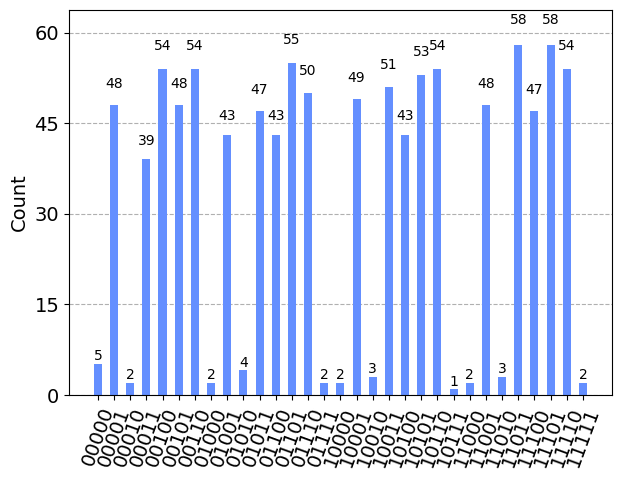

In [19]:
# Grover's algorithm simulation
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj, shots=1024).result()
counts = results.get_counts()
print("\nTotal count:",counts)
plot_histogram(counts)